In [1]:
# handling data
import numpy as np
import pandas as pd

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
import statsmodels.api as sm
from pygam import LinearGAM, PoissonGAM, s, l
from matplotlib import lines

# handling telomere length data
import fukushima_telomere_methods as f_tm

# for loading telo data column containing individual
# telomere length values, enables literal reading of a list as numbers
from ast import literal_eval

# setting all graphs to have darkgrid style w/ black edges for axes elements
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

# incase module requires reloading
import importlib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

---
&nbsp; 

...

&nbsp; 

---

# Mean Telomere Length & Dose

In [2]:
# Loading New Dose Quantifications (+age/sex data), Cortisol, Telomere FISH, and Dicentric Data

In [3]:
kelly_boar_dose = pd.read_csv('../excel data/cleaned/kelly_boar_dose.csv')
kelly_boar_teloFISH_df = pd.read_csv('../excel data/cleaned/kelly_boar_teloFISH_df.csv')
kelly_boar_teloFISH_df['teloFISH data'] = kelly_boar_teloFISH_df['teloFISH data'].apply(lambda row: np.array(literal_eval(row)))

## Merging Kelly's Telomere FISH data w/ New Dose Quantifications (+age/sex data)

In [4]:
# general cols of interest
general_cols_of_interest = ['Sample ID', 'Sex', 'Age (months)', 
                            'INTERNAL Life time dose, mGy 134+137',
                            'EXTERNAL Dose Reasonable Life Time, mGy (134+137)',
                            'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',
                            'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)'
                           ]

In [5]:
merge_kelly_teloFISH_dose = kelly_boar_teloFISH_df.merge(kelly_boar_dose, on=['Sample ID'])
teloFISH_cols = general_cols_of_interest + ['teloFISH means']

# selecting cols of interest 
merge_kelly_teloFISH_dose = merge_kelly_teloFISH_dose[teloFISH_cols].copy()

In [6]:
merge_kelly_teloFISH_dose.rename(columns={'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)': 
                                          'Dose rate (uGy per h)',
                                          'teloFISH means': 'Mean Telomere Length (FISH)'}, inplace=True)

merge_kelly_teloFISH_dose['encoded sex'] = merge_kelly_teloFISH_dose['Sex'].apply(lambda row: f_tm.encode_sex(row))
f_tm.enforce_col_types(merge_kelly_teloFISH_dose)

In [7]:
# saving for final writeup
merge_kelly_teloFISH_dose.to_csv('../excel data/cleaned/merge_kelly_teloFISH_dose.csv', index=False)

## Visualizing Mean Telomere Length vs. Dose

In [8]:
dose_types = ['INTERNAL Life time dose, mGy 134+137',
              'EXTERNAL Dose Reasonable Life Time, mGy (134+137)',
              'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',
              'Dose rate (uGy per h)']

Performing a multivariate linear regression between dose/age vs. telomere length, then storing the fitted models predictions of telomere length as 'y_pred'.. seeing how 'y_pred' looks plotted below

In [9]:
merge_kelly_teloFISH_dose['Age class'] = 'temp'
merge_kelly_teloFISH_dose['Age class'] = merge_kelly_teloFISH_dose['Age (months)'].apply(lambda row: f_tm.make_age_class(row))

In [10]:
merge_kelly_teloFISH_dose.head(3)

,Sample ID,Sex,Age (months),"INTERNAL Life time dose, mGy 134+137","EXTERNAL Dose Reasonable Life Time, mGy (134+137)","Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",Dose rate (uGy per h),Mean Telomere Length (FISH),encoded sex,Age class
0,1606103,Male,6,2.756694,68.208,70.964694,3.554446,0.439557,0.0,piglet
1,1607205,Male,1,0.034633,0.882,0.916633,0.727816,0.452469,0.0,piglet
2,1607221,Male,1,2.459387,17.640,20.099387,4.946150,0.533217,0.0,piglet


In [11]:
merge_kelly_teloFISH_dose.shape

(37, 10)

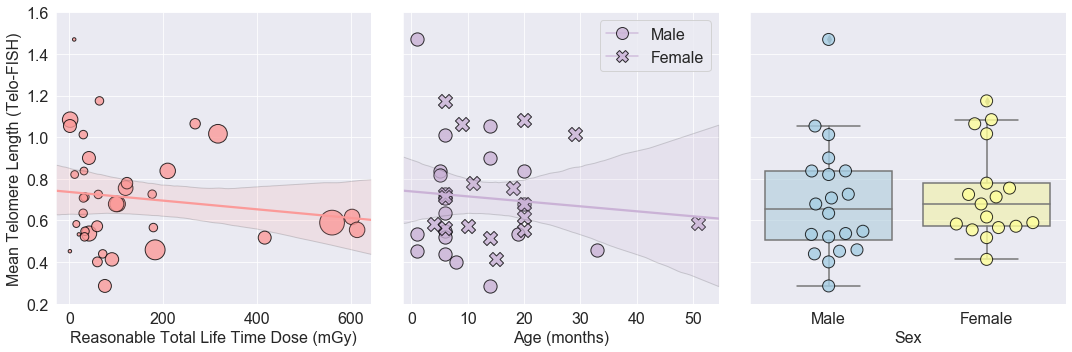

In [53]:
dose_type = ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',]

x2 = 'Age (months)'
x3 = 'Sex'
y = 'Mean Telomere Length (Telo-FISH)'

f_tm.graph_y_vs_dose_age_sex(df=merge_kelly_teloFISH_dose.rename({'Mean Telomere Length (FISH)':
                                                                  'Mean Telomere Length (Telo-FISH)'},
                                                                 axis=1),
                                                                 x=dose_type[0], x2=x2, x3=x3, y=y)

## OLS linear regression

In [11]:
merge_kelly_teloFISH_dose['encoded sex'] = merge_kelly_teloFISH_dose['Sex'].apply(lambda row: f_tm.encode_sex(row))

In [171]:
y = merge_kelly_teloFISH_dose['Mean Telomere Length (FISH)'].values.reshape(-1, 1)
y_name = 'teloFISH means'
dose_type = ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',]

reg = f_tm.linear_regression_scores_X_y(merge_kelly_teloFISH_dose, y, y_name, dose_type)

OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'] vs. teloFISH means --> R2: 0.0191
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)'] vs. teloFISH means --> R2: 0.0193
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'encoded sex'] vs. teloFISH means --> R2: 0.0436



In [172]:
df = merge_kelly_teloFISH_dose.copy()
df.rename({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':
           'Reasonable Total Life Time Dose (mGy)',
           'Mean Telomere Length (FISH)':
           'Mean Telomere Length (Telo-FISH)'}, axis=1, inplace=True)

df['constant'] = 1
endog = df['Mean Telomere Length (Telo-FISH)']
exog = df[['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 'encoded sex', 'constant']]

model = sm.OLS(endog, exog=exog, missing='none', hasconst=True)
results = model.fit()

# results.summary()

In [173]:
merge_kelly_teloFISH_dose.head(3)

,Sample ID,Sex,Age (months),"INTERNAL Life time dose, mGy 134+137","EXTERNAL Dose Reasonable Life Time, mGy (134+137)","Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",Dose rate (uGy per h),Mean Telomere Length (FISH),encoded sex,Age class
0,1606103,Male,6,2.756694,68.208,70.964694,3.554446,0.439557,0,piglet
1,1607205,Male,1,0.034633,0.882,0.916633,0.727816,0.452469,0,piglet
2,1607221,Male,1,2.459387,17.640,20.099387,4.946150,0.533217,0,piglet


## OLS multivariate linear regression results table

In [169]:
LRresult = (results.summary2().tables[1])
LRresult = LRresult.round(4).reset_index().rename({'index':'Independent variables',
                                                   't':'t statistic'}, axis=1)
LRresult.iloc[0, 0] = 'Reasonable Life Time Dose'
LRresult.iloc[2, 0] = 'Sex'
LRresult.iloc[3, 0] = 'Constant'
LRresult

,Independent variables,Coef.,Std.Err.,t statistic,P>|t|,[0.025,0.975]
0,Reasonable Life Time Dose,-0.0003,0.0004,-0.8956,0.3770,-0.0010,0.0004
1,Age (months),-0.0004,0.0054,-0.0782,0.9382,-0.0114,0.0105
2,Sex,0.0879,0.0960,0.9160,0.3663,-0.1073,0.2832
3,Constant,0.7159,0.0729,9.8269,0.0000,0.5677,0.8641


In [16]:
f_tm.render_mpl_table(LRresult.round(4), col_width=3.65, font_size=18,
                      path='graphs/main figures/OLS METRICS dose age sex vs mean telos FISH.png')

In [170]:
cols = pd.DataFrame({f'Dependent variable: {endog.name}':[''],
                     f'R2 score: {results.rsquared.round(4)}':['']})
f_tm.render_mpl_table(cols, col_width=7, font_size=18,
                      path='graphs/main figures/OLS dose age sex vs mean telos FISH COLUMNS.png')

## Generalized additive model 

In [22]:
df = merge_kelly_teloFISH_dose.copy()
df['constant'] = 1
df.rename({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':
           'Reasonable Total Life Time Dose mGy',
           'Mean Telomere Length (FISH)':
           'Mean Telomere Length (Telo-FISH)'}, axis=1, inplace=True)

y = df['Mean Telomere Length (Telo-FISH)']
X = df[['Reasonable Total Life Time Dose mGy', 'Age (months)', 'encoded sex',]]

lam = np.logspace(-3, 3, 3)
lams = [lam] * 3
# n_splines=25
# lam=100

gam = LinearGAM(s(0) + s(1) + l(2), fit_intercept=True).fit(X, y)
# gam = LinearGAM(s(0, lam=lam,) + s(1, lam=lam) + l(2,lam=lam), fit_intercept=True).fit(X, y)

gam.gridsearch(X, y, lam=lams,
               keep_best=True, 
              )

100% (27 of 27) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + l(2) + intercept, 
   tol=0.0001, verbose=False)

In [24]:
# gam.predict(X)

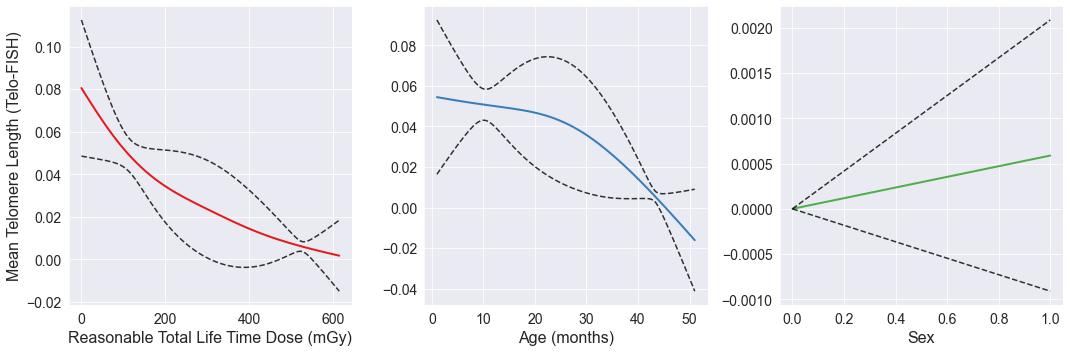

In [14]:
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=False, sharex=False)
fontsize=16

colors = sns.color_palette('Set1', len(df['Sample ID'].unique())), 
t = (1,)
test = [x + t for x in colors[0]]

titles = ['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 'Sex']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), color=test[i], linewidth=2)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='black', alpha=.8, ls='--')
    ax.set_xlabel(titles[i], fontsize=fontsize)
    ax.tick_params(labelsize=14)
axs[0].set_ylabel('Mean Telomere Length (Telo-FISH)', fontsize=fontsize)

plt.tight_layout()
# plt.savefig(f'graphs/main figures/GAM Mean Telomere Length (Telo-FISH) vs {titles}.png', dpi=600, bbox_inches='tight')

In [20]:
# df[titles]

In [15]:
import shap

In [27]:
explainer = shap.KernelExplainer(gam.predict, X)
shap_values = explainer.shap_values(X)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


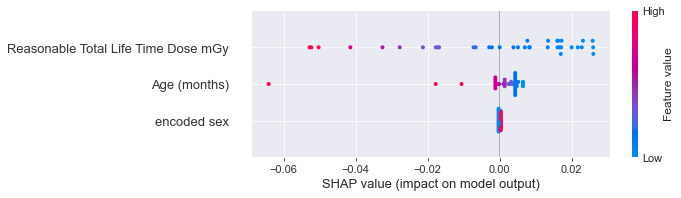

In [33]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

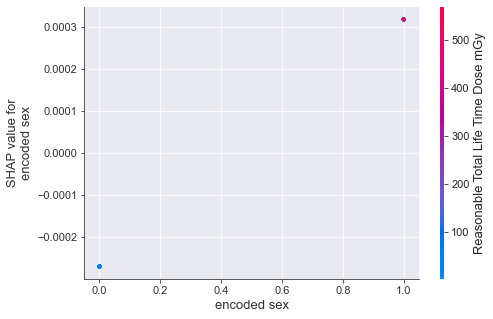

In [37]:
shap.dependence_plot(2, shap_values, X)

In [188]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.4691
Link Function:                     IdentityLink Log Likelihood:                                  -214.0857
Number of Samples:                           37 AIC:                                              433.1096
                                                AICc:                                             433.6205
                                                GCV:                                                0.0677
                                                Scale:                                              0.0629
                                                Pseudo R-Squared:                                   0.0237
Feature Function                  Lam

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


# Cortisol and Dose

In [12]:
prep_boar_cortisol_df = pd.read_csv('../excel data/cleaned/prep_boar_cortisol_df.csv')
aryn_boar_dose = pd.read_csv('../excel data/cleaned/aryn_boar_dose.csv')

# renaming for consistency between cols
aryn_boar_dose.rename(columns={'Dose rate (uGy/h) at time of capture (Int+Ext; 134+137)':
                               'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)'}, inplace=True)

# combining data
dose_cort_cols_interest = general_cols_of_interest + ['Cortisol (pg/mg)']

trim_kelly_dose_cortisol = f_tm.merge_return_df_cols_interest(kelly_boar_dose, prep_boar_cortisol_df, dose_cort_cols_interest)
trim_aryn_dose_cortisol = f_tm.merge_return_df_cols_interest(aryn_boar_dose, prep_boar_cortisol_df, dose_cort_cols_interest)
total_dose_cortisol = pd.concat([trim_kelly_dose_cortisol, trim_aryn_dose_cortisol], axis=0).reset_index(drop=True)

# renaming col & enforcing col types
total_dose_cortisol.rename(columns={'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)': 
                                    'Dose rate (uGy per h)'}, inplace=True)

f_tm.enforce_col_types(total_dose_cortisol)

total_dose_cortisol['encoded sex'] = total_dose_cortisol['Sex'].apply(lambda row: f_tm.encode_sex(row))

# saving for final writeup
total_dose_cortisol.to_csv('../excel data/cleaned/total_dose_cortisol.csv', index=False)
total_dose_cortisol.to_excel('../excel data/cleaned/total_dose_cortisol.xlsx', index=False)

In [13]:
total_dose_cortisol.head()

,Sample ID,Sex,Age (months),"INTERNAL Life time dose, mGy 134+137","EXTERNAL Dose Reasonable Life Time, mGy (134+137)","Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",Dose rate (uGy per h),Cortisol (pg/mg),encoded sex
0,1607261,Female,20,29.200071,584.6400,613.840071,15.849122,6.736842,1
1,1607262,Male,20,4.997361,204.6240,209.621361,3.316593,7.087576,0
2,1607264,Female,18,31.137820,88.7040,119.841820,5.162829,5.360000,1
3,1607281,Female,15,18.031323,72.6264,90.657723,2.257504,5.445329,1
4,1611301O210,Female,51,42.943361,517.4400,560.383361,2.411084,17.120000,1


In [14]:
total_dose_cortisol.shape

(27, 9)

## Visualizing Cortisol vs. Dose

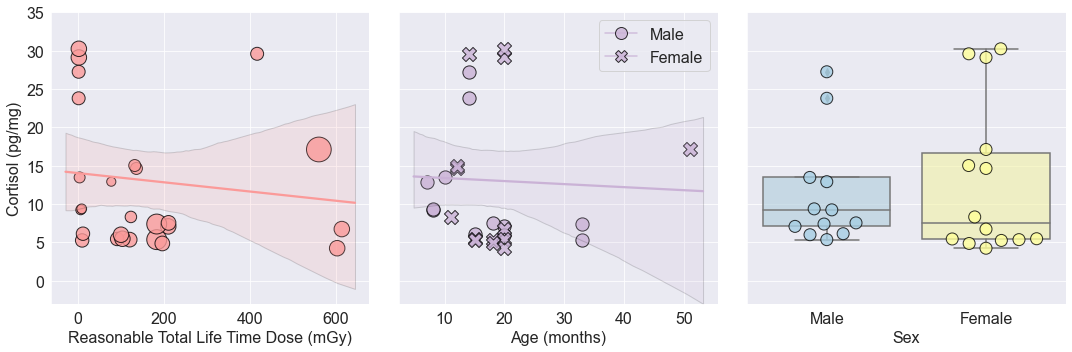

In [15]:
dose_type = ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',]

x2 = 'Age (months)'
x3 = 'Sex'
y = 'Cortisol (pg/mg)'

f_tm.graph_y_vs_dose_age_sex(df=total_dose_cortisol, x=dose_type[0], x2=x2, x3=x3, y=y)

In [16]:
# aryn_boar_dose.head(3)

In [17]:
def extract_month(row):
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
              5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September',
              10: 'October', 11: 'November', 12: 'December'}
    month = int(row[2:4])
    return months[month]

def extract_year(row):
    year = row[0:2]
    return '20'+year

total_dose_cortisol['Month captured'] = total_dose_cortisol['Sample ID'].apply(lambda row: extract_month(row))
total_dose_cortisol['Year captured'] = total_dose_cortisol['Sample ID'].apply(lambda row: extract_year(row))

In [18]:
from matplotlib.patches import Rectangle

blank = Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False)

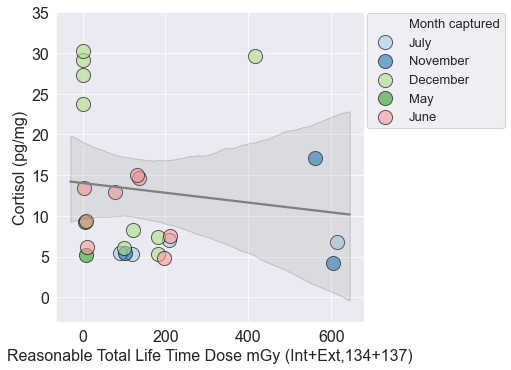

In [19]:
x = 'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
y = 'Cortisol (pg/mg)'
hue='Month captured'

df = total_dose_cortisol.copy()

fontsize=16

colors = sns.color_palette('Paired', len(df['Sample ID'].unique())), 
t = (0.7,)
test = [x + t for x in colors[0]]

# DOSE vs. cortisol
sns.lmplot(x=x, y=y, data=df, palette=test, hue=hue, height=5, 
           aspect=1, legend=False, fit_reg=False,
           scatter_kws={'alpha':.6, 'linewidth':1, 'edgecolor':'black', 's':200})

plt.xlabel(x, fontsize=fontsize)
plt.ylabel(y, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

sns.regplot(x=x, y=y, data=df, ax=ax, color='gray',
           fit_reg=True, scatter_kws={'alpha':.6, 'linewidth':1, 'edgecolor':'black', 's':0})

ax.set_ylim(-3, 35)
y_name = y.replace('/', '')

plt.legend([blank] + handles, ['Month captured'] + labels, loc='upper left', bbox_to_anchor=(.99, 1.02),
           fancybox=True, markerscale=1, fontsize=13)

# plt.savefig(f'graphs/main figures/{hue} Cortisol vs {x}.png', dpi=600, bbox_inches='tight')

In [22]:
# total_dose_cortisol['log mass log length'] = total_dose_cortisol['']

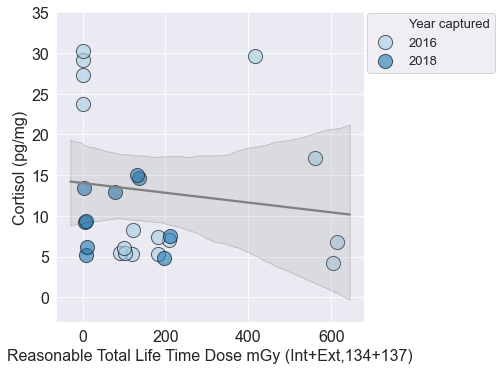

In [20]:
x = 'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
y = 'Cortisol (pg/mg)'
hue='Year captured'

df = total_dose_cortisol.copy()

fontsize=16

colors = sns.color_palette('Paired', len(df['Sample ID'].unique())), 
t = (0.7,)
test = [x + t for x in colors[0]]

# DOSE vs. cortisol
sns.lmplot(x=x, y=y, data=df, palette=test, hue=hue, height=5, 
           aspect=1, legend=False, fit_reg=False,
           scatter_kws={'alpha':.6, 'linewidth':1, 'edgecolor':'black', 's':200})

plt.xlabel(x, fontsize=fontsize)
plt.ylabel(y, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

sns.regplot(x=x, y=y, data=df, ax=ax, color='gray',
           fit_reg=True, scatter_kws={'alpha':.6, 'linewidth':1, 'edgecolor':'black', 's':0})

ax.set_ylim(-3, 35)
y_name = y.replace('/', '')

plt.legend([blank] + handles, [hue] + labels, loc='upper left', bbox_to_anchor=(.99, 1.02),
           fancybox=True, markerscale=1, fontsize=13)

# plt.savefig(f'graphs/main figures/{hue} Cortisol vs {x}.png', dpi=600, bbox_inches='tight')

In [23]:
merge_tom_data_cortisol = pd.read_csv('../excel data/cleaned/merge_tom_data_cortisol.csv')
merge_tom_data_cortisol.head(3)

,Sample ID,Sex,Age (months),"INTERNAL Life time dose, mGy 134+137","EXTERNAL Dose Reasonable Life Time, mGy (134+137)","Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",Dose rate (uGy per h),Cortisol (pg/mg),encoded sex,Month,Year,mass (kg),length (cm),girth (cm)
0,1607261,Female,20,29.200071,584.640,613.840071,15.849122,6.736842,1,July,2016,38.7,107.0,68.8
1,1607262,Male,20,4.997361,204.624,209.621361,3.316593,7.087576,0,July,2016,69.0,128.5,93.6
2,1607264,Female,18,31.137820,88.704,119.841820,5.162829,5.360000,1,July,2016,43.6,112.9,75.5


In [31]:
merge_tom_data_cortisol.shape

(24, 14)

In [24]:
merge_tom_data_cortisol['log mass log length'] = np.log(merge_tom_data_cortisol['mass (kg)']) / np.log(merge_tom_data_cortisol['length (cm)'])

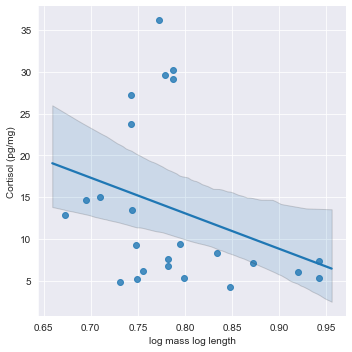

In [25]:
sns.lmplot(x='log mass log length', y='Cortisol (pg/mg)', data=merg)

In [ ]:
'maybe very guarded'

'kind of fatter'

'producing cort expensive.. '

'0 dose.. '

'all bodily indicators suggest higher fitness.. '



'cortsiol & telomeres'

In [29]:
merge_tom_data_cortisol.corr()

,Age (months),"INTERNAL Life time dose, mGy 134+137","EXTERNAL Dose Reasonable Life Time, mGy (134+137)","Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",Dose rate (uGy per h),Cortisol (pg/mg),encoded sex,Year,mass (kg),length (cm),girth (cm),log mass log length
Age (months),1.000000,0.504292,0.295113,0.314870,-0.001046,-0.139163,-0.031342,-0.537135,0.804462,0.730137,0.710135,0.774065
"INTERNAL Life time dose, mGy 134+137",0.504292,1.000000,0.514756,0.556088,0.514460,-0.442227,0.139981,-0.095383,0.287722,0.176357,0.237080,0.310886
"EXTERNAL Dose Reasonable Life Time, mGy (134+137)",0.295113,0.514756,1.000000,0.998802,0.561192,-0.171971,0.357129,-0.314129,0.167887,0.117212,0.118412,0.234952
"Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",0.314870,0.556088,0.998802,1.000000,0.573394,-0.191951,0.354198,-0.309968,0.179174,0.123693,0.128321,0.245510
Dose rate (uGy per h),-0.001046,0.514460,0.561192,0.573394,1.000000,0.152320,0.155462,0.172814,-0.158350,-0.206612,-0.188957,-0.143198
Cortisol (pg/mg),-0.139163,-0.442227,-0.171971,-0.191951,0.152320,1.000000,0.037637,-0.123373,-0.318155,-0.175797,-0.378477,-0.307619
encoded sex,-0.031342,0.139981,0.357129,0.354198,0.155462,0.037637,1.000000,-0.174825,-0.277398,-0.232280,-0.363559,-0.209914
Year,-0.537135,-0.095383,-0.314129,-0.309968,0.172814,-0.123373,-0.174825,1.000000,-0.565982,-0.619957,-0.404284,-0.619891
mass (kg),0.804462,0.287722,0.167887,0.179174,-0.158350,-0.318155,-0.277398,-0.565982,1.000000,0.897811,0.952147,0.971273
length (cm),0.730137,0.176357,0.117212,0.123693,-0.206612,-0.175797,-0.232280,-0.619957,0.897811,1.000000,0.874398,0.884721


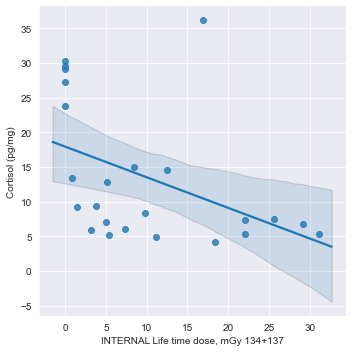

In [28]:
sns.lmplot(x='INTERNAL Life time dose, mGy 134+137', y='Cortisol (pg/mg)', data=merge_tom_data_cortisol)

In [32]:
set(total_dose_cortisol['Sample ID']) - set(merge_tom_data_cortisol['Sample ID'])

{'1607281', '1611301O210', '1611302O211'}

In [34]:
# total_dose_cortisol

OLS | Reasonable Total Life Time Dose mGy (Int+Ext,134+137) vs. Cortisol (pg/mg) --> R2: 0.0368
OLS | Age (months) vs. Cortisol (pg/mg) --> R2: 0.0194
OLS | mass (kg) vs. Cortisol (pg/mg) --> R2: 0.1012
OLS | girth (cm) vs. Cortisol (pg/mg) --> R2: 0.1432
OLS | length (cm) vs. Cortisol (pg/mg) --> R2: 0.0309


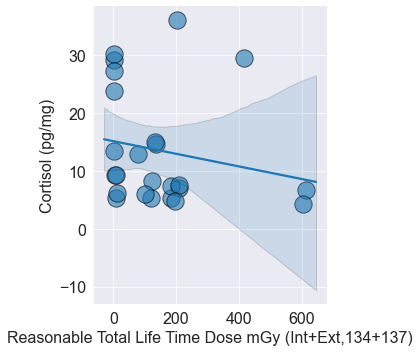

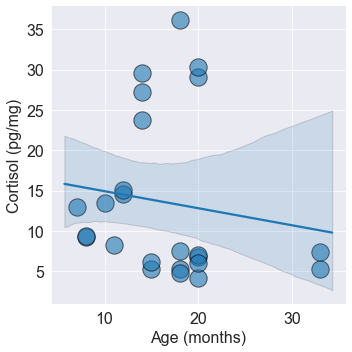

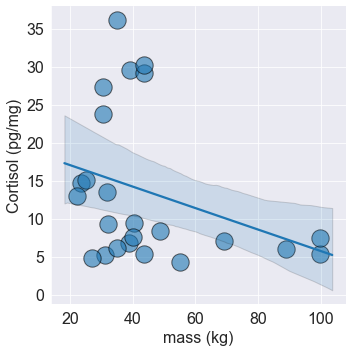

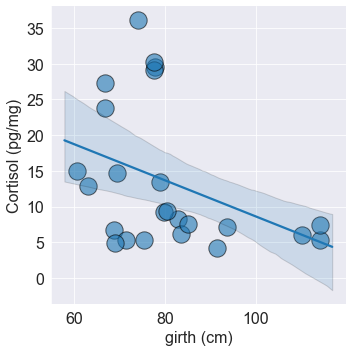

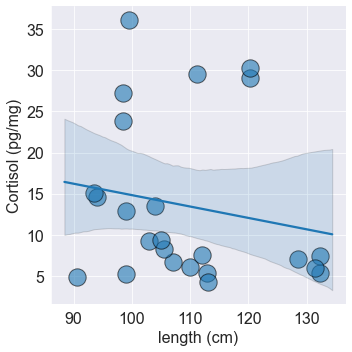

In [26]:
x = 'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
y = 'Cortisol (pg/mg)'
hue=None

df = merge_tom_data_cortisol.copy()

fontsize=16

colors = sns.color_palette('Paired', len(df['Sample ID'].unique())), 
t = (0.7,)
test = [x + t for x in colors[0]]

for x in ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'mass (kg)', 
          'girth (cm)', 'length (cm)']:
    # DOSE vs. cortisol
    sns.lmplot(x=x, y=y, data=df, palette=test, hue=hue, height=5, aspect=1, legend=False,
                scatter_kws={'alpha':.6, 'linewidth':1, 'edgecolor':'black', 's':300})

    plt.xlabel(x, fontsize=fontsize)
    plt.ylabel(y, fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()

#     plt.legend([blank] + handles, ['Month'] + labels, loc='upper left', bbox_to_anchor=(.99, 1.02),
#                fancybox=True, markerscale=1, fontsize=13)

    plt.tight_layout()
    
    X = df[x].values.reshape(-1, 1)
    y_t = df[y].values.reshape(-1, )
    fit_lm = LinearRegression().fit(X, y_t)
    print(f'OLS | {x} vs. {y} --> R2: {fit_lm.score(X, y_t):.4f}')
#     plt.savefig(f'graphs/main figures/Cortisol vs {x}.png', dpi=600, bbox_inches='tight')

In [27]:
merge_tom_data_cortisol.corr()

,Age (months),"INTERNAL Life time dose, mGy 134+137","EXTERNAL Dose Reasonable Life Time, mGy (134+137)","Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",Dose rate (uGy per h),Cortisol (pg/mg),encoded sex,Year,mass (kg),length (cm),girth (cm)
Age (months),1.000000,0.504292,0.295113,0.314870,-0.001046,-0.139163,-0.031342,-0.537135,0.804462,0.730137,0.710135
"INTERNAL Life time dose, mGy 134+137",0.504292,1.000000,0.514756,0.556088,0.514460,-0.442227,0.139981,-0.095383,0.287722,0.176357,0.237080
"EXTERNAL Dose Reasonable Life Time, mGy (134+137)",0.295113,0.514756,1.000000,0.998802,0.561192,-0.171971,0.357129,-0.314129,0.167887,0.117212,0.118412
"Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",0.314870,0.556088,0.998802,1.000000,0.573394,-0.191951,0.354198,-0.309968,0.179174,0.123693,0.128321
Dose rate (uGy per h),-0.001046,0.514460,0.561192,0.573394,1.000000,0.152320,0.155462,0.172814,-0.158350,-0.206612,-0.188957
Cortisol (pg/mg),-0.139163,-0.442227,-0.171971,-0.191951,0.152320,1.000000,0.037637,-0.123373,-0.318155,-0.175797,-0.378477
encoded sex,-0.031342,0.139981,0.357129,0.354198,0.155462,0.037637,1.000000,-0.174825,-0.277398,-0.232280,-0.363559
Year,-0.537135,-0.095383,-0.314129,-0.309968,0.172814,-0.123373,-0.174825,1.000000,-0.565982,-0.619957,-0.404284
mass (kg),0.804462,0.287722,0.167887,0.179174,-0.158350,-0.318155,-0.277398,-0.565982,1.000000,0.897811,0.952147
length (cm),0.730137,0.176357,0.117212,0.123693,-0.206612,-0.175797,-0.232280,-0.619957,0.897811,1.000000,0.874398


## OLS linear regression

In [93]:
dose_type = ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',]
y = total_dose_cortisol['Cortisol (pg/mg)'].values.reshape(-1, 1)
y_name = 'cortisol'

reg = f_tm.linear_regression_scores_X_y(total_dose_cortisol, y, y_name, dose_type)

OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'] vs. cortisol --> R2: 0.0130
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)'] vs. cortisol --> R2: 0.0136
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'encoded sex'] vs. cortisol --> R2: 0.0146



In [94]:
df = total_dose_cortisol.copy()
df.rename({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':
           'Reasonable Total Life Time Dose (mGy)'}, axis=1, inplace=True)

df['constant'] = 1
endog = df['Cortisol (pg/mg)']
exog = df[['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 'encoded sex', 'constant']]

model = sm.OLS(endog, exog=exog, missing='none', hasconst=True)
results = model.fit()

# results.summary()

## OLS multivariate linear regression results table

In [79]:
LRresult = (results.summary2().tables[1])
LRresult = LRresult.round(4).reset_index().rename({'index':'Independent variables',
                                                   't':'t statistic'}, axis=1)
LRresult.iloc[0, 0] = 'Reasonable Life Time Dose'
LRresult.iloc[2, 0] = 'Sex'
LRresult.iloc[3, 0] = 'Constant'
# LRresult

In [33]:
f_tm.render_mpl_table(LRresult.round(4), col_width=3.65, font_size=18,
                      path='graphs/main figures/OLS METRICS dose age sex vs cortisol.png')

In [34]:
cols = pd.DataFrame({f'Dependent variable: {endog.name}':[''],
                     f'R2 score: {results.rsquared.round(4)}':['']})
f_tm.render_mpl_table(cols, col_width=7, font_size=18,
                      path=f'graphs/main figures/OLS dose age sex vs cortisol COLUMNS.png')

## Linear generalized additive model

In [48]:
df = total_dose_cortisol.copy()
df['constant'] = 1
df.rename({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':
           'Reasonable Total Life Time Dose mGy'}, axis=1, inplace=True)

y = df['Cortisol (pg/mg)']
X = df[['Reasonable Total Life Time Dose mGy', 'Age (months)', 'encoded sex',]]

lam = np.logspace(-3, 3, 3)
lams = [lam] * 3
# n_splines=25
# lam=1000

gam = LinearGAM(s(0, basis='ps', 
#                   lam=1000,
                 ) + s(1, 
#                        lam=1
                      ) + l(2, 
#                             lam=lam
                           ), fit_intercept=True).fit(X, y)
gam.gridsearch(X, y, lam=lams,
               keep_best=True, 
              )

100% (27 of 27) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + l(2) + intercept, 
   tol=0.0001, verbose=False)

In [49]:
# gam.summary()

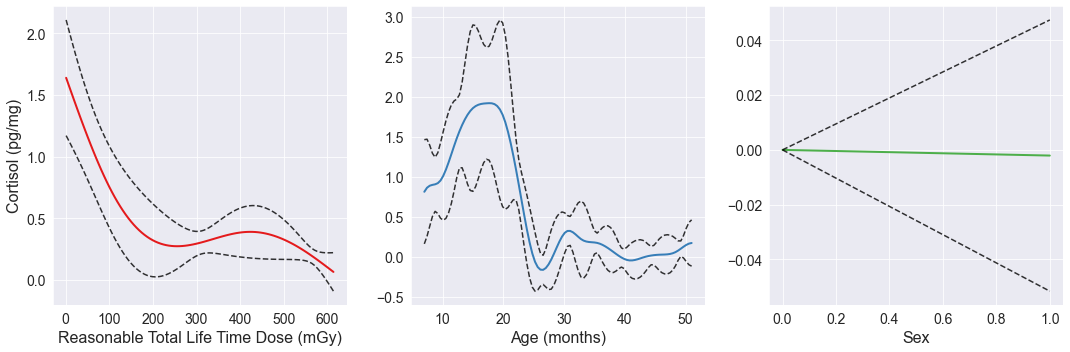

In [50]:
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=False, sharex=False)
fontsize=16

colors = sns.color_palette('Set1', len(df['Sample ID'].unique())), 
t = (1,)
test = [x + t for x in colors[0]]

titles = ['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 'Sex']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), color=test[i], linewidth=2)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='black', alpha=.8, ls='--')
    ax.set_xlabel(titles[i], fontsize=fontsize)
    ax.tick_params(labelsize=14)
axs[0].set_ylabel('Cortisol (pg/mg)', fontsize=fontsize)

plt.tight_layout()
# plt.savefig(f'graphs/main figures/GAM Cortisol vs {titles}.png', dpi=600, bbox_inches='tight')

In [80]:
# explainer = shap.KernelExplainer(gam.predict, X)
explainer = shap.SamplingExplainer(gam.predict, X)
shap_values = explainer.shap_values(X)

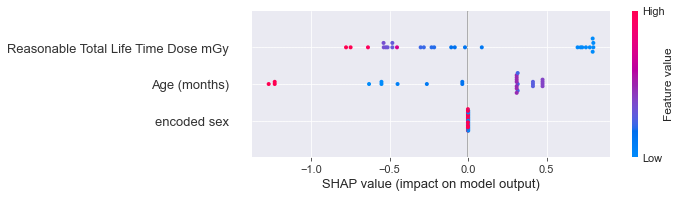

In [52]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [79]:
# shap.dependence_plot?

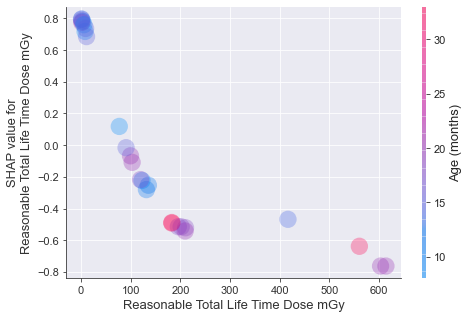

In [85]:
shap.dependence_plot(0, shap_values, X, alpha=.3, dot_size=300,)

# Aryn Data (telomere length qPCR)

## Boar qPCR data

In [31]:
aryn_boar_df = pd.read_csv('../excel data/cleaned/aryn_boar_df.csv')
aryn_boar_df.drop(['Sex'], axis=1, inplace=True)

In [35]:
qPCR_cols_interest = general_cols_of_interest + ['Normalized T/A Average (Average Telomere Length)']

#aryn_boar_dose is loaded above in the cortisol section
aryn_qPCR_dose = f_tm.merge_return_df_cols_interest(aryn_boar_dose, aryn_boar_df, qPCR_cols_interest)
aryn_qPCR_dose.replace(to_replace=' ', value=np.NaN, inplace=True)
aryn_qPCR_dose.dropna(axis=0, inplace=True)
aryn_qPCR_dose.rename(columns={'Normalized T/A Average (Average Telomere Length)': 
                               'Mean Telomere Length (qPCR)',
                               'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)': 
                               'Dose rate (uGy per h)'}, inplace=True)

f_tm.enforce_col_types(aryn_qPCR_dose)

In [34]:
# saving for final writeup
aryn_qPCR_dose.to_csv('../excel data/cleaned/aryn_boar_qPCR_dose.csv', index=False)

### Visualizing Mean Telomere Length vs. Dose

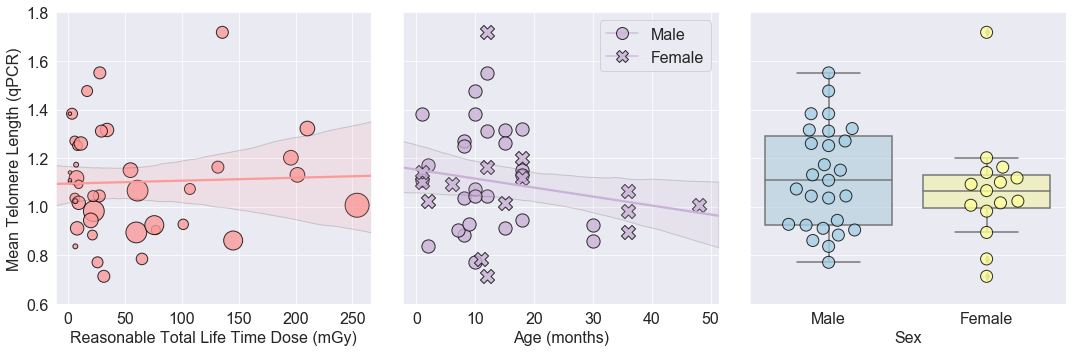

In [62]:
x = 'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
x3 = 'Sex'
x2 = 'Age (months)'
y = 'Mean Telomere Length (qPCR)'

f_tm.graph_y_vs_dose_age_sex(df=aryn_qPCR_dose, x=x, x2=x2, x3=x3, y=y)

## OLS linear regression

In [66]:
aryn_qPCR_dose['encoded sex'] = aryn_qPCR_dose['Sex'].apply(lambda row: f_tm.encode_sex(row))

In [68]:
x = ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)']
y = aryn_qPCR_dose['Mean Telomere Length (qPCR)'].values.reshape(-1, 1)
y_name = 'Mean Telomere Length (qPCR)'

reg = f_tm.linear_regression_scores_X_y(aryn_qPCR_dose, y, y_name, x)

OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'] vs. Mean Telomere Length (qPCR) --> R2: 0.0014
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)'] vs. Mean Telomere Length (qPCR) --> R2: 0.0579
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'encoded sex'] vs. Mean Telomere Length (qPCR) --> R2: 0.0632



In [122]:
df = aryn_qPCR_dose.copy()
df.rename({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':
           'Reasonable Total Life Time Dose (mGy)'}, axis=1, inplace=True)

df['constant'] = 1
endog = df['Mean Telomere Length (qPCR)']
exog = df[['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 'encoded sex', 'constant']]

model = sm.OLS(endog, exog=exog, missing='none', hasconst=True)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Mean Telomere Length (qPCR)   R-squared:                       0.063
Model:                                     OLS   Adj. R-squared:                 -0.011
Method:                          Least Squares   F-statistic:                    0.8544
Date:                         Sun, 19 Apr 2020   Prob (F-statistic):              0.473
Time:                                 21:29:34   Log-Likelihood:                 6.6537
No. Observations:                           42   AIC:                            -5.307
Df Residuals:                               38   BIC:                             1.643
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Reasonable Total Life Time Dose (mGy)     0.0006      0.001      0.994      0.327      -0.001       0.002
Age (months)                             -0.0052      0.004     -1.372      0.178      -0.013       0.002
encoded sex                              -0.0334      0.073     -0.461      0.647      -0.180       0.113
constant                                  1.1535      0.057     20.223      0.000       1.038       1.269
==============================================================================
Omnibus:                        2.738   Durbin-Watson:                   1.465
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                1.824
Skew:                           0.490   Prob(JB):                        0.402
Kurtosis:                       3.288   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
test = pd.DataFrame({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':[1000], 
                     'Age (months)':[15], 
                     'encoded sex':[0],
                     'constant':1})


results.predict(test)

0    1.670381
dtype: float64

## OLS multivariate linear regression results table

In [66]:
LRresult = (results.summary2().tables[1])
LRresult = LRresult.round(4).reset_index().rename({'index':'Independent variables',
                                                   't':'t statistic'}, axis=1)
LRresult.iloc[0, 0] = 'Reasonable Life Time Dose'
LRresult.iloc[2, 0] = 'Sex'
LRresult.iloc[3, 0] = 'Constant'
LRresult

,Independent variables,Coef.,Std.Err.,t statistic,P>|t|,[0.025,0.975]
0,Reasonable Life Time Dose,0.0006,0.0006,0.9937,0.3267,-0.0006,0.0018
1,Age (months),-0.0052,0.0038,-1.3724,0.1780,-0.0129,0.0025
2,Sex,-0.0334,0.0725,-0.4610,0.6474,-0.1802,0.1134
3,Constant,1.1535,0.0570,20.2228,0.0000,1.0380,1.2690


In [67]:
f_tm.render_mpl_table(LRresult.round(4), col_width=3.65, font_size=18,
                      path='graphs/main figures/OLS METRICS dose age sex vs mean telos qPCR.png')

In [68]:
cols = pd.DataFrame({f'Dependent variable: {endog.name}':[''],
                     f'R2 score: {results.rsquared.round(4)}':['']})
f_tm.render_mpl_table(cols, col_width=7, font_size=18,
                      path=f'graphs/main figures/OLS dose age sex vs {endog.name} COLUMNS.png')

In [72]:
df = aryn_qPCR_dose.copy()
df['constant'] = 1
df.rename({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':
           'Reasonable Total Life Time Dose mGy'}, axis=1, inplace=True)

y = df['Mean Telomere Length (qPCR)']
X = df[['Reasonable Total Life Time Dose mGy', 'Age (months)', 'encoded sex',]]

lam = np.logspace(-3, 3, 3)
lams = [lam] * 3
# n_splines=25
lam=100

gam = LinearGAM(s(0, 
                  lam=lam
                 ) + s(1, 
                       lam=lam
                      ) + l(2, 
                            lam=lam
                           ), fit_intercept=True).fit(X, y)
gam.gridsearch(X, y, lam=lams,
               keep_best=True, 
              )

100% (27 of 27) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + l(2) + intercept, 
   tol=0.0001, verbose=False)

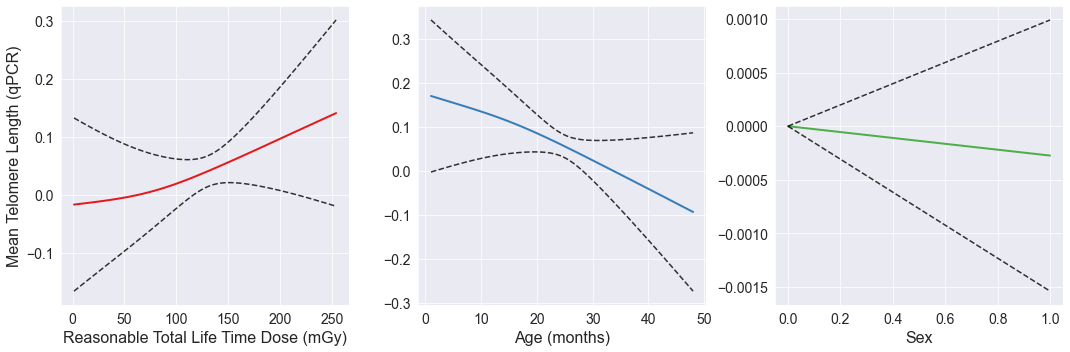

In [73]:
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=False, sharex=False)
fontsize=16

colors = sns.color_palette('Set1', len(df['Sample ID'].unique())), 
t = (1,)
test = [x + t for x in colors[0]]

titles = ['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 'Sex']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), color=test[i], linewidth=2)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='black', alpha=.8, ls='--')
    ax.set_xlabel(titles[i], fontsize=fontsize)
    ax.tick_params(labelsize=14)
axs[0].set_ylabel('Mean Telomere Length (qPCR)', fontsize=fontsize)

plt.tight_layout()
# plt.savefig(f'graphs/main figures/GAM Mean Telomere Length (qPCR) vs {titles}.png', dpi=600, bbox_inches='tight')

## Snake qPCR data

In [238]:
aryn_snake_df = pd.read_csv('../excel data/cleaned/aryn_snake_df.csv')
# aryn_snake_df.drop(10, axis=0, inplace=True)
# aryn_snake_df


aryn_snake_df['Sex'] = aryn_snake_df['Sex'].apply(lambda row: f_tm.male_or_female(row))
aryn_snake_df['encode sex'] = aryn_snake_df['Sex'].apply(lambda row: f_tm.encode_sex(row))

In [239]:
# saving for later writeup
aryn_snake_df.to_csv('../excel data/cleaned/aryn_snake_df.csv', index=False)

In [267]:
aryn_snake_df.shape

(20, 8)

### Visualizing Mean Telomere Length vs. Dose rate

In [242]:
def snake_graph_y_vs_dose_age_sex(df=None, x=None, x2=None, x3=None, y=None, hue=None,):
    f, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=False)
    
    fontsize=16
    
    colors = sns.color_palette('Paired', len(df['Sample ID'].unique())), 
    t = (0.7,)
    test = [x + t for x in colors[0]]
    
    # DOSE vs. Y
    sns.regplot(x=x, y=y, data=df, ax=axes[0], color=test[6],
                scatter_kws={'alpha':.8, 'linewidth':1, 'edgecolor':'black',
                             's':160,
#                              's':df['Mass (g)']*.7
                            })

    # SEX vs. Y
    palette_cust = {'Male':test[0], 'Female':test[10]}
    sns.boxplot(x=x3, y=y, dodge=True, palette=palette_cust, order=['Male', 'Female'], data=df, ax=axes[1],)
    
    for patch in axes[1].artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .6))
        
    sns.swarmplot(x=x3, y=y, dodge=True, palette=palette_cust, order=['Male', 'Female'], data=df, ax=axes[1],
                  size=12, edgecolor='black', linewidth=1, **{'alpha':0.8})

    x_name = 'Total dose rates (μGy h-1)'
    axes[0].set_xlabel(x_name, fontsize=fontsize)
    axes[0].set_ylabel(y, fontsize=fontsize)
    axes[0].tick_params(labelsize=fontsize)
    
    axes[1].set_xlabel(x3, fontsize=fontsize)
    axes[1].set_ylabel('', fontsize=fontsize)
    axes[1].tick_params(labelsize=fontsize)

#     axes[0].set_xlim(-50,700)
#     axes[1].set_xlim(-4,55)

#     axes[0].set_ylim(0.2,1.6)
#     axes[1].set_ylim(0.2,1.6)
    plt.tight_layout()
    plt.savefig(f'graphs/main figures/snake mean telos sex dose.png', dpi=600, bbox_inches='tight')

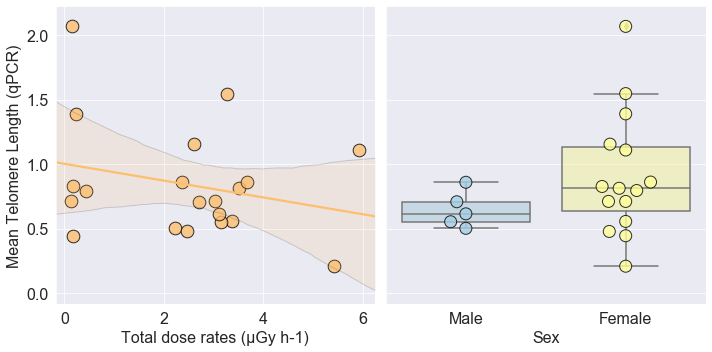

In [235]:
snake_graph_y_vs_dose_age_sex(df=aryn_snake_df, x='Total dose rates (μGy h-1) meth1', 
                              x3='Sex', y='Mean Telomere Length (qPCR)', )

In [276]:
df.head()

,Sample ID,Sex,Mean Telomere Length (qPCR),Total length (cm),Mass (g),Total dose rates (μGy h-1),Total dose rates (μGy h-1) meth2,encode sex,constant
0,CEC10,Female,0.444298,113.7,218.72,0.171601,0.304258,1,1
1,CEC18,Female,0.826190,108.3,206.50,0.168549,0.107030,1,1
2,CEC22,Female,2.067214,91.9,104.50,0.156359,0.032642,1,1
3,CEC23,Female,1.389182,106.7,204.50,0.223530,0.182350,1,1
4,CEC5,Female,0.710565,85.9,123.30,0.138233,0.093048,1,1


In [269]:
df = aryn_snake_df.copy()
df['constant'] = 1
df.rename({'Total dose rates (μGy h-1) meth1':
           'Total dose rates (μGy h-1)'}, axis=1, inplace=True)

y = df['Mean Telomere Length (qPCR)']
X = df[['Total dose rates (μGy h-1)', 'encode sex', 'constant']]

lam = np.logspace(-3, 3, 3)
lams = [lam] * 2
n_splines=25
lam=100

gam = LinearGAM(s(0, lam=lam) + l(1, lam=lam), fit_intercept=True).fit(X, y)
gam.gridsearch(X, y, lam=lams,
               keep_best=True, 
              )

100% (9 of 9) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + intercept, 
   tol=0.0001, verbose=False)

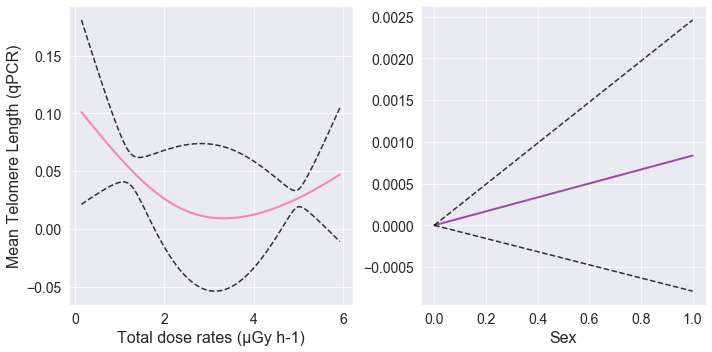

In [274]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=False, sharex=False)
fontsize=16

colors = sns.color_palette('Set1', len(df['Sample ID'].unique())), 
t = (1,)
test = [x + t for x in colors[0]]

titles = ['Total dose rates (μGy h-1)', 'Sex']
for i, ax in enumerate(axs):
    if i == 0:
        color = test[7]
    elif i ==1:
        color = test[3]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), color=color, linewidth=2)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='black', alpha=.8, ls='--')
    ax.set_xlabel(titles[i], fontsize=fontsize)
    ax.tick_params(labelsize=14)
axs[0].set_ylabel('Mean Telomere Length (qPCR)', fontsize=fontsize)

plt.tight_layout()
plt.savefig(f'graphs/main figures/GAM Mean Telomere Length (qPCR) vs {titles} SNAKES.png', dpi=600, bbox_inches='tight')

## Multivariate linear regression

In [277]:
aryn_snake_df.head(3)

,Sample ID,Sex,Mean Telomere Length (qPCR),Total length (cm),Mass (g),Total dose rates (μGy h-1) meth1,Total dose rates (μGy h-1) meth2,encode sex
0,CEC10,Female,0.444298,113.7,218.72,0.171601,0.304258,1
1,CEC18,Female,0.826190,108.3,206.50,0.168549,0.107030,1
2,CEC22,Female,2.067214,91.9,104.50,0.156359,0.032642,1


In [281]:
df = aryn_snake_df.copy()
df.rename({'Total dose rates (μGy h-1) meth1':
           'Total dose rates (μGy h-1)'}, axis=1, inplace=True)

df['constant'] = 1
endog = df['Mean Telomere Length (qPCR)']
exog = df[['Total dose rates (μGy h-1)', 'encode sex', 'constant']]

model = sm.OLS(endog, exog=exog, missing='none', hasconst=True)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Mean Telomere Length (qPCR)   R-squared:                       0.128
Model:                                     OLS   Adj. R-squared:                  0.025
Method:                          Least Squares   F-statistic:                     1.247
Date:                         Sat, 18 Apr 2020   Prob (F-statistic):              0.312
Time:                                 11:47:23   Log-Likelihood:                -9.7163
No. Observations:                           20   AIC:                             25.43
Df Residuals:                               17   BIC:                             28.42
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Total dose rates (μGy h-1)    -0.0587      0.057     -1.029      0.318      -0.179       0.062
encode sex                     0.2403      0.222      1.085      0.293      -0.227       0.708
constant                       0.8062      0.246      3.282      0.004       0.288       1.324
==============================================================================
Omnibus:                        4.500   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                2.650
Skew:                           0.861   Prob(JB):                        0.266
Kurtosis:                       3.464   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## OLS multivariate linear regression results table

In [283]:
LRresult = (results.summary2().tables[1])
LRresult = LRresult.round(4).reset_index().rename({'index':'Independent variables',
                                                   't':'t statistic'}, axis=1)
LRresult.iloc[0, 0] = 'Total dose rates (μGy h-1)'
LRresult.iloc[1, 0] = 'Sex'
LRresult.iloc[2, 0] = 'Constant'
LRresult

,Independent variables,Coef.,Std.Err.,t statistic,P>|t|,[0.025,0.975]
0,Total dose rates (μGy h-1),-0.0587,0.0571,-1.0288,0.3180,-0.1791,0.0617
1,Sex,0.2403,0.2215,1.0847,0.2932,-0.2271,0.7076
2,Constant,0.8062,0.2456,3.2821,0.0044,0.2879,1.3244


In [284]:
f_tm.render_mpl_table(LRresult.round(4), col_width=3.65, font_size=18,
                      path='graphs/main figures/snake OLS METRICS dose sex vs mean telos qPCR.png')

In [285]:
cols = pd.DataFrame({f'Dependent variable: {endog.name}':[''],
                     f'R2 score: {results.rsquared.round(4)}':['']})
f_tm.render_mpl_table(cols, col_width=7, font_size=18,
                      path=f'graphs/main figures/snake OLS dose sex vs {endog.name} COLUMNS.png')

In [271]:
# gam.summary()

### Statistics

In [ ]:
features_list = [['Total dose rates μGy h-1'], ['Total dose rates μGy h-1', 'encode sex']]

for features in features_list:
#     if 'encode sex' in features:
#         aryn_snake_df.dropna(axis=0, inplace=True)
    y = aryn_snake_df['Mean Telomere Length (qPCR)'].values.reshape(-1, 1)
    X = aryn_snake_df[features].values.reshape(-1, len(features))
    fit_lm = LinearRegression().fit(X, y)
    
    print(f'OLS | {features} vs. Mean Telomere Length (qPCR) --> R2: {fit_lm.score(X, y):.4f}')

# Dicentrics and Dose

In [99]:
kelly_boar_dicentrics_df = pd.read_csv('../excel data/cleaned/kelly_boar_dicentrics_df.csv')

dicentrics_cols = general_cols_of_interest + ['Average Dicentrics per cell']
merge_dicentrics_dose = f_tm.merge_return_df_cols_interest(kelly_boar_dose, kelly_boar_dicentrics_df, dicentrics_cols)

merge_dicentrics_dose.rename(columns={'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)': 
                                      'Dose rate (uGy per h)'}, inplace=True)

# saving for later writeup
merge_dicentrics_dose.to_csv('../excel data/cleaned/merge_dicentrics_dose.csv', index=False)

merge_dicentrics_dose.rename({'Average Dicentrics per cell': 'Average # of dicentrics per cell'}, axis=1, inplace=True)
merge_dicentrics_dose['encoded sex'] = merge_dicentrics_dose['Sex'].apply(lambda row: f_tm.encode_sex(row))

## Visualizing Dicentrics vs. Dose

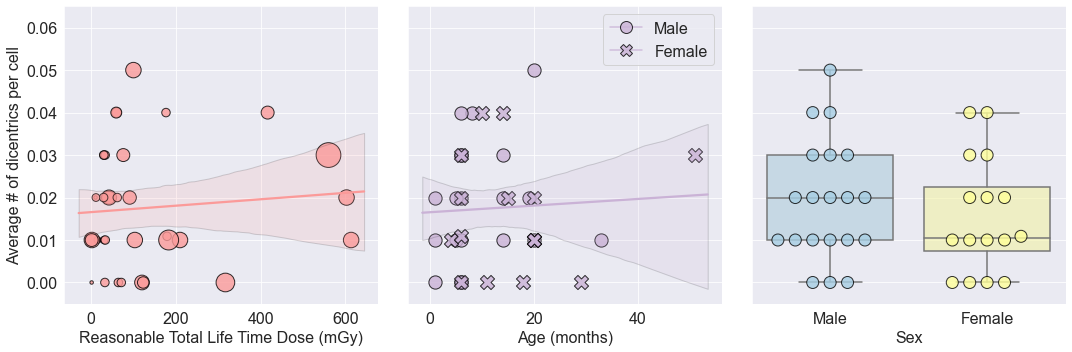

In [98]:
dose_type = ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',]

x2 = 'Age (months)'
x3 = 'Sex'
y = 'Average # of dicentrics per cell'

f_tm.graph_y_vs_dose_age_sex(df=merge_dicentrics_dose, x=dose_type[0], x2=x2, x3=x3, y=y)

## OLS linear regression

In [55]:
x = ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)']
y = merge_dicentrics_dose['Average # of dicentrics per cell'].values.reshape(-1, 1)
y_name = 'Dicentrics'

reg = f_tm.linear_regression_scores_X_y(merge_dicentrics_dose, y, y_name, x)

OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'] vs. Dicentrics --> R2: 0.0085
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)'] vs. Dicentrics --> R2: 0.0085
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'encoded sex'] vs. Dicentrics --> R2: 0.0418



In [100]:
df = merge_dicentrics_dose.copy()
df.rename({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':
           'Reasonable Total Life Time Dose (mGy)'}, axis=1, inplace=True)

df['constant'] = 1
endog = df['Average # of dicentrics per cell']
exog = df[['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 'encoded sex', 'constant']]

model = sm.OLS(endog, exog=exog, missing='none', hasconst=True)
results = model.fit()

# results.summary()

In [102]:
# test = pd.DataFrame({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':[100_000], 
#                      'Age (months)':[8], 
#                      'encoded sex':[0],
#                      'constant':1})
# results.predict(test)

## OLS multivariate linear regression results table

In [103]:
LRresult = (results.summary2().tables[1])
LRresult = LRresult.round(6).reset_index().rename({'index':'Independent variables',
                                                   't':'t statistic'}, axis=1)
LRresult.iloc[0, 0] = 'Reasonable Life Time Dose'
LRresult.iloc[2, 0] = 'Sex'
LRresult.iloc[3, 0] = 'Constant'
LRresult

,Independent variables,Coef.,Std.Err.,t statistic,P>|t|,[0.025,0.975]
0,Reasonable Life Time Dose,0.000015,0.000020,0.758244,0.453853,-0.000025,0.000055
1,Age (months),0.000007,0.000301,0.023730,0.981216,-0.000606,0.000620
2,Sex,-0.005602,0.005311,-1.054792,0.299420,-0.016420,0.005216
3,Constant,0.018049,0.004012,4.498754,0.000085,0.009877,0.026221


In [135]:
f_tm.render_mpl_table(LRresult.round(4), col_width=3.65, font_size=18,
                      path='graphs/main figures/OLS METRICS dose age sex vs dicentrics.png')

In [136]:
cols = pd.DataFrame({f'Dependent variable: {endog.name}':[''],
                     f'R2 score: {results.rsquared.round(4)}':['']})
f_tm.render_mpl_table(cols, col_width=7, font_size=18,
                      path=f'graphs/main figures/OLS dose age sex vs DICENTRICS COLUMNS.png')

## Linear generalized additive modeling

In [162]:
df = merge_dicentrics_dose.copy()
df['constant'] = 1
df.rename({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':
           'Reasonable Total Life Time Dose mGy'}, axis=1, inplace=True)

y = df['Average # of dicentrics per cell']
X = df[['Reasonable Total Life Time Dose mGy', 
        'Age (months)', 
#         'encoded sex'
       ]]

# lam = np.logspace(-3, 3, 3)
# lams = [lam] * 3
# n_splines=25
# lam=100

lam = np.logspace(-2, 2, 2)
lams = [lam] * 2

gam = LinearGAM(s(0,) + s(1,) 
#                 l(2,)
                , 
                fit_intercept=True).fit(X, y)
gam.gridsearch(X, y, lam=lams,
               keep_best=True, 
              )

100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

In [163]:
# test = pd.DataFrame({'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)':[100_000], 
#                      'Age (months)':[8], 
#                      'encoded sex':[0],
#                      'constant':1})

# gam.predict(test.drop(['constant'], axis=1))

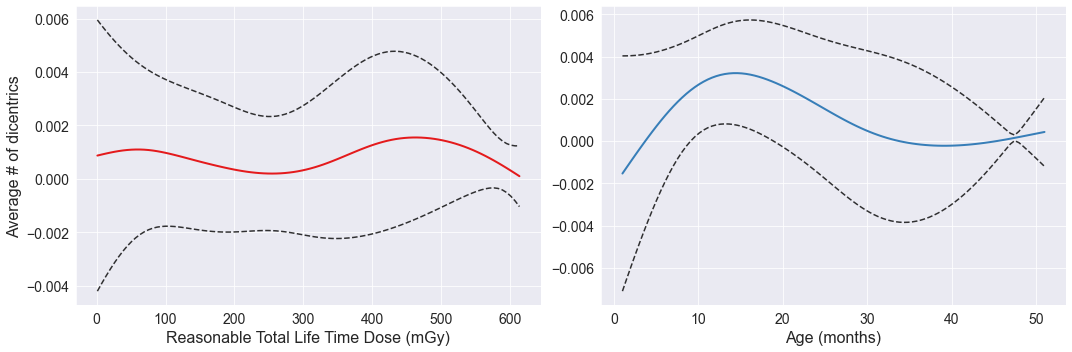

In [165]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=False, sharex=False)
fontsize=16

colors = sns.color_palette('Set1', len(df['Sample ID'].unique())), 
t = (1,)
test = [x + t for x in colors[0]]

titles = ['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 
#           'Sex'
         ]
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), color=test[i], linewidth=2)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='black', alpha=.8, ls='--')
    ax.set_xlabel(titles[i], fontsize=fontsize)
    ax.tick_params(labelsize=14)
axs[0].set_ylabel('Average # of dicentrics', fontsize=fontsize)

plt.tight_layout()
# plt.savefig(f'graphs/main figures/GAM Dicentrics vs {titles}.png', dpi=600, bbox_inches='tight')

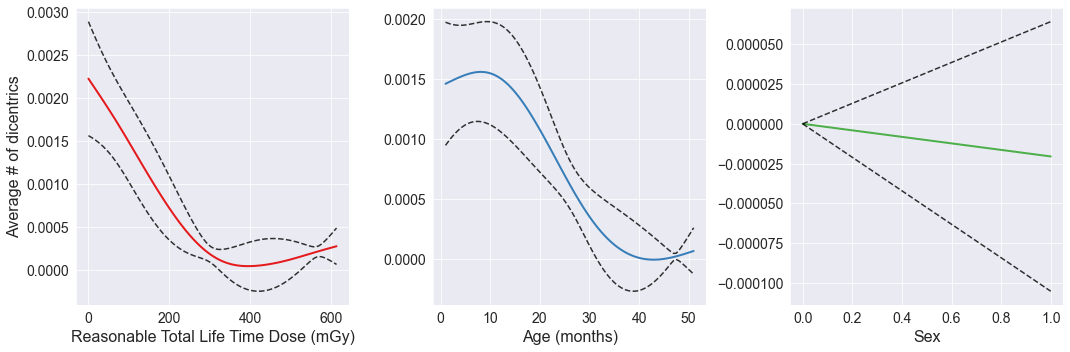

In [110]:
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=False, sharex=False)
fontsize=16

colors = sns.color_palette('Set1', len(df['Sample ID'].unique())), 
t = (1,)
test = [x + t for x in colors[0]]

titles = ['Reasonable Total Life Time Dose (mGy)', 'Age (months)', 'Sex']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), color=test[i], linewidth=2)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='black', alpha=.8, ls='--')
    ax.set_xlabel(titles[i], fontsize=fontsize)
    ax.tick_params(labelsize=14)
axs[0].set_ylabel('Average # of dicentrics', fontsize=fontsize)

plt.tight_layout()
# plt.savefig(f'graphs/main figures/GAM Dicentrics vs {titles}.png', dpi=600, bbox_inches='tight')

In [107]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.1182
Link Function:                     IdentityLink Log Likelihood:                                -90262.8135
Number of Samples:                           36 AIC:                                           180529.8634
                                                AICc:                                          180530.2652
                                                GCV:                                                0.0002
                                                Scale:                                              0.0002
                                                Pseudo R-Squared:                                  -0.0085
Feature Function                  Lam

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


# Misc data representations